# data612 - Group Project 3 : Recommender System (Matrix Factorization)
# date: 2019-06-25
# by: Sang Yoon (Andy) Hwang, Santosh Cheruku, Anthony Munoz

The purpose of this project is to show which algorithm works the best for prediction - SVD, NMF and ALS (the lowest RMSE).
We will use the algorithm that works the best to predict user ratings and recommend items.

# Data Preparation

We are going to use 100k ratings dataset from movielens.

In [68]:
import pandas as pd
import numpy as np
import surprise
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Dataset
from surprise import KNNBasic
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

From https://grouplens.org/datasets/movielens/, ml-latest-small will be used.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/wheremagichappens/an.dy/master/data612/ml-100k/ratings.csv')

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Just to make our life a little bit easier, we will change the names of the columns.

In [4]:
df.columns = ['user','item','rating','timestamp']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
user         100836 non-null int64
item         100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# Modelling

We will find the best algorithm based on RMSE. 

In [6]:
reader = Reader(rating_scale=(df.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

Let's split data into 5 folds

In [52]:
data.split(n_folds=5)

# SVD

In [53]:
algo = surprise.SVD()
rmse_svd = surprise.evaluate(algo, data, measures=['RMSE'])

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\surprise\evaluate.py:66: UserWarning:

The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning:

Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 



Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.8682
------------
Fold 2
RMSE: 0.8805
------------
Fold 3
RMSE: 0.8709
------------
Fold 4
RMSE: 0.8660
------------
Fold 5
RMSE: 0.8755
------------
------------
Mean RMSE: 0.8722
------------
------------


In [54]:
# result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
# result['test_rmse'] 

# Non-negative Matrix Factorization

In [55]:
algo = surprise.NMF()
rmse_nmf = surprise.evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm NMF.

------------
Fold 1


C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\surprise\evaluate.py:66: UserWarning:

The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning:

Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 



RMSE: 0.9183
------------
Fold 2
RMSE: 0.9231
------------
Fold 3
RMSE: 0.9172
------------
Fold 4
RMSE: 0.9174
------------
Fold 5
RMSE: 0.9218
------------
------------
Mean RMSE: 0.9196
------------
------------


In [ ]:
#result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
#result['test_rmse'] 

# BaselineOnly

In [56]:
algo = surprise.BaselineOnly()
rmse_bo = surprise.evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm BaselineOnly.

------------

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\surprise\evaluate.py:66: UserWarning:

The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning:

Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 




Fold 1
Estimating biases using als...
RMSE: 0.8672
------------
Fold 2
Estimating biases using als...
RMSE: 0.8801
------------
Fold 3
Estimating biases using als...
RMSE: 0.8685
------------
Fold 4
Estimating biases using als...
RMSE: 0.8689
------------
Fold 5
Estimating biases using als...
RMSE: 0.8746
------------
------------
Mean RMSE: 0.8719
------------
------------


In [57]:
#result = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
#result['test_rmse'] 

Surprisingly, BaselineOnly is the winner! It means we will use ALS. We will now test accuracy using training set on test set.

# BaselineOnly - ALS

We will perform train/test (80/20) split to create model. 

In [58]:
trainset, testset = train_test_split(data, test_size=.20)

We will configure ALS parameter for BaselineOnly

In [59]:
bsl_options = {'method': 'als'}
algo = surprise.BaselineOnly(bsl_options=bsl_options)

# Train the algorithm on the trainset, and predict ratings for the testset
predictions_als = algo.fit(trainset).test(testset)

# Then compute RMSE
accuracy.rmse(predictions_als)

Estimating biases using als...
RMSE: 0.8722


0.8721730340648061

Let's create DataFrame using prediction result.

In [60]:
prediction_df = pd.DataFrame(predictions_als)
prediction_df.head()

,uid,iid,r_ui,est,details
0,372,593,4.0,3.851799,{'was_impossible': False}
1,343,52328,5.0,3.684146,{'was_impossible': False}
2,425,2028,4.0,3.958603,{'was_impossible': False}
3,474,425,3.5,3.362062,{'was_impossible': False}
4,410,4037,4.0,3.936751,{'was_impossible': False}


Let's select worst/top 10 prediction results on testset.

In [61]:
worst_10 = abs(prediction_df['r_ui'] - prediction_df['est']).sort_values(ascending=False).head(10)
top_10 = abs(prediction_df['r_ui'] - prediction_df['est']).sort_values(ascending=True).head(10)

Worst 10 - it was way off.

In [62]:
prediction_df.iloc[worst_10.index]

,uid,iid,r_ui,est,details
15456,543,89904,0.5,4.645293,{'was_impossible': False}
5907,573,3996,0.5,4.490088,{'was_impossible': False}
18126,105,4027,0.5,4.374198,{'was_impossible': False}
14761,598,593,0.5,4.313111,{'was_impossible': False}
16009,393,541,0.5,4.307906,{'was_impossible': False}
6159,258,122886,0.5,4.157864,{'was_impossible': False}
12135,573,1127,0.5,4.105295,{'was_impossible': False}
14076,426,47,0.5,4.091590,{'was_impossible': False}
14928,594,7116,0.5,4.079693,{'was_impossible': False}
13621,413,4816,0.5,4.043972,{'was_impossible': False}


Best 10 - it predicted perfectly.

In [63]:
prediction_df.iloc[top_10.index]

,uid,iid,r_ui,est,details
12688,122,1208,5.0,5.000000,{'was_impossible': False}
7333,452,541,5.0,5.000000,{'was_impossible': False}
1325,34,6242,3.5,3.500057,{'was_impossible': False}
1084,606,1172,4.0,4.000317,{'was_impossible': False}
5460,570,2959,4.0,4.000347,{'was_impossible': False}
436,448,55830,3.0,3.000383,{'was_impossible': False}
14831,599,3328,3.0,3.000386,{'was_impossible': False}
5120,182,493,3.5,3.500431,{'was_impossible': False}
11455,156,922,4.0,3.999542,{'was_impossible': False}
15918,462,148626,3.5,3.499525,{'was_impossible': False}


We can also use individual uid and iid to check individual prediciton result. Let's select one of the options in testset.

In [64]:
test_10 = testset[0:10]

In [65]:
# prediction using training set compare the results with testset
uid = test_10[1][0]   # raw user id (as in the ratings file).
iid = test_10[1][1]   # raw item id (as in the ratings file).

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=test_10[1][2], verbose=True)

user: 343        item: 52328      r_ui = 5.00   est = 3.68   {'was_impossible': False}


We will then recommend top 5 movies by predicted ratings for any selected user. This time, I will merge item title data set with rating data set.

In [66]:
item_names = pd.read_csv('https://raw.githubusercontent.com/wheremagichappens/an.dy/master/data612/ml-100k/movies.csv')
item_names = item_names.iloc[:,[0,1]]
item_names.columns = ['iid', 'title']
prediction_df = prediction_df.merge(item_names, on = 'iid', how = 'inner')

In [67]:
def recommender_user(uid):
    top_5 = prediction_df[prediction_df.uid == uid].sort_values(by = 'est', ascending = False).head(5)
    for i in range(len(top_5)):
        print('top 5 movies for uid: {0} are iid: {1} - {2} with predicted ratings of {3}'.format(uid, top_5.iid.values[i], top_5.title.values[i], top_5.est.values[i]))

recommender_user(uid)

top 5 movies for uid: 343 are iid: 318 - Shawshank Redemption, The (1994) with predicted ratings of 4.426584043337352
top 5 movies for uid: 343 are iid: 1221 - Godfather: Part II, The (1974) with predicted ratings of 4.291701657264001
top 5 movies for uid: 343 are iid: 1198 - Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) with predicted ratings of 4.273272901420321
top 5 movies for uid: 343 are iid: 527 - Schindler's List (1993) with predicted ratings of 4.255834192835689
top 5 movies for uid: 343 are iid: 2571 - Matrix, The (1999) with predicted ratings of 4.221124135793197


# Conclusion - Evaluation

In [70]:
rmse_models = [np.mean(rmse_svd['rmse']),np.mean(rmse_nmf['rmse']),np.mean(rmse_bo['rmse'])]
rmse_df = pd.DataFrame(rmse_models)
rmse_df.index = ['SVD','NMF','BaselineOnly']
rmse_df.columns = ['RMSE - CV 5 folds']

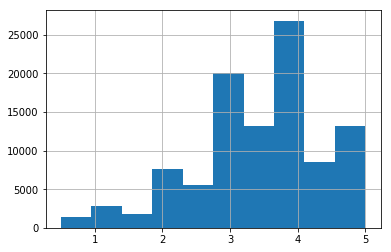

In [74]:
df.rating.hist()

In [71]:
rmse_df

,RMSE - CV 5 folds
SVD,0.872198
NMF,0.919557
BaselineOnly,0.871888


Our first thought that SVD would give us the best result but it did not as RMSE for SVD is little bit higher than BaselineOnly's. We cannot, however, strictly say that one should always prefer ALS based BaselineOnly to SGD based SVD - depending on the case, one can still use SVD if that is more suitable for his/her own purpose. 

We then have to think about why SVD had higher RMSE. 

Our guess is that it could be something to do with feature scaling issue - how ratings are scaled. 
From the documentation of the dataset we used (http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) and from the rating historgram, we know that ratings are half-star incremented. On the other hand, alternative dataset with 1 million ratings, which we could not run SVD due to the memory issue, (http://files.grouplens.org/datasets/movielens/ml-1m-README.txt) contains whole-star ratings only. 

According to benchmark RMSE examples on http://surpriselib.com/, we see that RMSE for SVD using 100k dataset is usually around 0.934 but only 0.873 using 1m dataset.

Since SVD is based on SGD, (https://scikit-learn.org/stable/modules/sgd.html) there are several disdvantages - 1) SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations. 2) SGD is sensitive to feature scaling.

For the future reference, it will be a worth try to compare the RMSE of each model one another in different rating scales to see if there will be any improvement.